# Generator와 Discriminator  
Generator는 무작위 난수 이미지를 입력받아 가짜 이미지를 생성한다  
Discriminator는 가짜 이미지를 보고 진짜인지 가짜인지 확인한다  
Discriminator가 가짜라고 인식했다면 Generator에게 피드백을 보낸다 -> 결과가 0.8이라면 0.2를 전달한다, predict와 loss로 학습하는 개념이 아니라 피드백으로 학습하는 개념  
Discriminator는 진짜와 가짜를 잘 구분하는 쪽으로 Generator는 진짜에 가까운 이미지를 만드는 쪽으로 학습된다.






In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
tf.__version__

'2.15.0'

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data() #숫자데이터
X_train.shape

(60000, 28, 28)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5 #-1에서 1로 정규화

In [ ]:
buffer_size = 60000
batch_size = 128

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
X_train #None은 이미지 수, 여러 조각(배치)으로 나누어서 실행

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
#Step 1 : (i,j)위치의 input픽셀 하나를 선택하여 그 값을 필터에 곱한다
#Step 2 : 그 필터의 값을 (i*s, j*s)위치에 넣는다 (필터 통째로, s는 stride)
#Step 3 : 겹치는 부분이 있으면 더한다
#Step 4 : 이것은 input의 사이즈를 (s∗i−1) x (s∗i−1)로 증가시킨다
#https://lsjsj92.tistory.com/416

def build_generator():
  network = tf.keras.Sequential()
  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7,7,256)))
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.summary()
  return network


In [ ]:
generator = build_generator()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_4 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 128)        

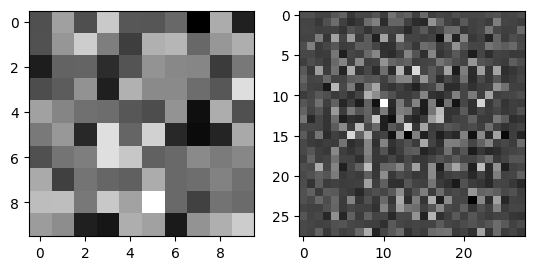

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.subplot(1, 2, 1)
plt.imshow(tf.reshape(noise, (10, 10)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1)) #시그모이드를 사용하지 않음 -> 결과값은 나중에 확률로 변환
  network.summary()
  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.001454]], dtype=float32)>

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(expected_output, fake_output): #분류기의 성능 측정
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #output이랑 똑같은 shape의 값만 다른 거
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output): #생성자의 성능 측정
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [ ]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim]) #256, 10*10의 랜덤 이미지가 생성됨
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True) #랜덤이미지를 학습 -> 가짜 이미지 생성
    expected_output = discriminator(images, training=True) #진짜 이미지를 학습 -> 진짜 예측값
    fake_output = discriminator(generated_images, training = True) # 가짜이미지 -> 가짜 예측값
    gen_loss = generator_loss(fake_output) # 가짜 예측값 -> 생성기의 오차
    disc_loss = discriminator_loss(expected_output, fake_output) #진짜 예측값 & 가짜 예측값 -> 분류기의 오차

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #오차를 기반으로 최적화할 가중치를 계산
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #업데이트할 가중치를 모델에 적용
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #업데이트할 가중치를 모델에 적용

In [ ]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_steps(image_batch)
    print("Epochs : ", epoch)
    generated_images = generator(test_images, training=False)
    fig= plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [ ]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])
train(X_train, epochs, test_images)

2.15.0
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_16 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_17 (Ba  (None, 7, 7, 128)

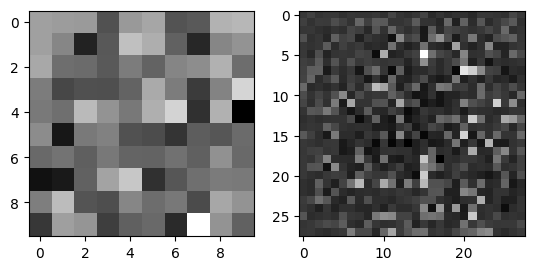

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)            

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
print(tf.__version__)  # 버전 출력을 위한 print 함수 사용

(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5

buffer_size = 60000
batch_size = 128

# 데이터셋 셔플과 배치를 정의하는 부분은 변경할 필요가 없으므로 그대로 유지
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

def build_generator():
  network = tf.keras.Sequential()
  # 생성자 네트워크 정의는 문제가 없어 보이므로 변경 없음
  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7,7,256)))
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.summary()
  return network

generator = build_generator()

noise = tf.random.normal([1, 100])  # noise_dim을 사용하는 대신 직접 숫자를 입력
generated_image = generator(noise, training=False)
plt.subplot(1, 2, 1)
plt.imshow(tf.reshape(noise, (10, 10)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

def build_discriminator():
  network = tf.keras.Sequential()
  # 판별자 네트워크 정의는 문제가 없으므로 변경 없음
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  network.add(layers.Flatten())
  network.add(layers.Dense(1))
  network.summary()
  return network

discriminator = build_discriminator()

discriminator(generated_image, training=False)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):  # 변수명 변경: expected_output -> real_output
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # 학습률 수정은 필요 없으나 일관성을 위해 변경
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

epochs = 50  # 테스트를 위해 epoch 수를 조정할 수 있음
noise_dim = 100
num_images_to_generate = 16

# train_step 함수 이름 수정: train_steps -> train_step, TensorFlow 컨벤션을 따름
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)  # 가짜 이미지 생성
    real_output = discriminator(images, training=True)  # 진짜 이미지 판별
    fake_output = discriminator(generated_images, training=True)  # 가짜 이미지 판별
    gen_loss = generator_loss(fake_output)  # 생성자 손실 계산
    disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실 계산
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # 생성자 가중치에 대한 기울기 계산
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # 판별자 가중치에 대한 기울기 계산
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # 생성자 가중치 업데이트
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # 판별자 가중치 업데이트


def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
    print("Epochs : ", epoch)
    generated_images = generator(test_images, training=False)
    fig= plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

test_images = tf.random.normal([num_images_to_generate, 100])
train(X_train, epochs, test_images)

